# 3. Excluding and unambiguous measurements for three symmetric qutrits 

In this notebook unambiguous and excluding measurement strategies are applied to three symmetric qutrits.
The excluding strategy mantains the excluding POVM which, as it has been discused in the main work, it is not optimal (once one state is discriminated we should change to unambiguous measurement).

Cells 1-3 define the needed parameters and functions.

Cell 4 computes a loop of sequential tests with fixed error and plots the average n vs the overlap c for both measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

In [2]:
def probability_matrix(states, POVMs):
    prob_matrix = np.zeros((len(states), len(POVMs)),dtype = 'complex_')
    for k in range(len(states)):
        for i in range(len(POVMs)):
            prob_matrix[k,i] = np.dot(np.dot(np.transpose(np.conjugate(states[k])),POVMs[i]),states[k])
    return np.real(prob_matrix)   

def likelihood_ratio(tirs,prob_matrix, priors):
    a,b,c = priors[0],priors[1],priors[2]
    # prob_matrix[0].shape[1] és el nombre de outputs
    for k in range(prob_matrix[0].shape[0]):
        a *=  prob_matrix[0,k]**tirs[k]
        b *=  prob_matrix[1,k]**tirs[k]
        c *=  prob_matrix[2,k]**tirs[k]
    return np.array((a/(a+b+c),b/(a+b+c), c/(a+b+c)))

In [3]:
u = np.array((1, cmath.exp(1j*(2*np.pi/3)),cmath.exp(1j*(4*np.pi/3))))
U = cmath.exp(-1j*(4*np.pi/3))*np.diag(u)
alpha = 0.001
prior0= 1/3
prior1 = 1/3
prior2 = 1/3
priors = [prior0,prior1,prior2]

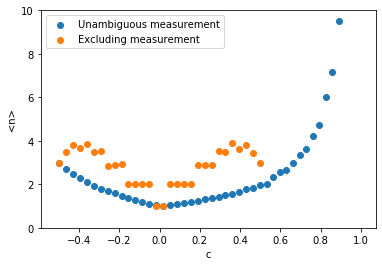

In [5]:
particions = 30
loops = 1000
vect_c1 = np.linspace(-0.499,0.5,particions)
vect_c2 = np.linspace(0.5,0.99,int(particions/2+1))
vect_c2 = np.delete(vect_c2,0)
vect_c = np.concatenate((vect_c1,vect_c2))

n_promig0 = np.zeros(len(vect_c))
n_promig1 = np.zeros(len(vect_c1))
for k in range(len(vect_c)):
    c = vect_c[k]
    psi0 = np.array([np.sqrt((1-c)/3),np.sqrt((1-c)/3),np.sqrt((1+2*c)/3)])
    psi1 = np.dot(U,psi0)
    psi2 = np.dot(U,psi1)
    states = [psi0,psi1,psi2]
    
    #Unambiguous
    R = np.matrix([np.conj(psi0), np.conj(psi1), np.conj(psi2)])
    invR = np.linalg.inv(R) 

    uphi0 = invR[:,0]
    uphi1 = invR[:,1]
    uphi2 = invR[:,2]
    ephi0 = 1/(np.sqrt(3))*np.array([1,-1,0])
    ephi1 = np.dot(U,ephi0)
    ephi2 = np.dot(U,ephi1)
    mu = np.amin((1-c,1+2*c))
    
    F0 = mu* np.tensordot(uphi0,np.transpose(np.conjugate(uphi0)), axes = 1)
    F1 = mu* np.tensordot(uphi1,np.transpose(np.conjugate(uphi1)), axes = 1)
    F2 = mu* np.tensordot(uphi2,np.transpose(np.conjugate(uphi2)), axes = 1)
    if c <= 0:
        E0 = -3*c/(1-c)*np.tensordot(ephi0,np.transpose(np.conjugate(ephi0)), axes = 0)
        E1 = -3*c/(1-c)*np.tensordot(ephi1,np.transpose(np.conjugate(ephi1)), axes = 0)
        E2 = -3*c/(1-c)*np.tensordot(ephi2,np.transpose(np.conjugate(ephi2)), axes = 0)
        POVMs0 = [F0,F1,F2,E0,E1,E2]
    else:
        Fns = np.identity(3)-F0-F1-F2
        POVMs0 = [F0,F1,F2,Fns]

    #Excluding     
    if c<=0.5:
        angle = np.arccos((-1/2)*np.sqrt((1+2*c)/(1-c)))
        excphi0 = 1/(np.sqrt(3))*np.array([cmath.exp(1j*angle),cmath.exp(-1j*angle),1])
        excphi1 = np.dot(U,excphi0)
        excphi2 = np.dot(U,excphi1)

        E0 = np.tensordot(excphi0,np.transpose(np.conjugate(excphi0)), axes = 0)
        E1 = np.tensordot(excphi1,np.transpose(np.conjugate(excphi1)), axes = 0)
        E2 = np.tensordot(excphi2,np.transpose(np.conjugate(excphi2)), axes = 0)
        POVMs1 = [E0,E1,E2]

    errors0 = 0
    errors1 = 0
    n_tirades0 = []
    n_tirades1 = []
    for o in range(2):
        if o == 1 and c<=0.5:
            POVMs = POVMs1
            errors = errors1

        
        else:
            POVMs = POVMs0
            errors = errors0
        
        prob_matrix = probability_matrix(states, POVMs)  
        prob_matrix = np.around(prob_matrix, 10)
        for i in range (loops):
            estat = np.random.choice(3, p = priors)
            m = 1
            output = 0
            tirs = np.zeros(len(POVMs))

            tirades=[0]
            while m >= 0:
                output =  np.random.choice(len(POVMs), p = prob_matrix[estat,:])
                tirades.append(output)
                tirs[output] += 1
                n = m

                for i in range(3):
                    if likelihood_ratio(tirs,prob_matrix,priors)[i]>=1-alpha:
                        m = -10
                        if i != estat:
                            errors += 1
                m+=1

            if o == 1 and c<= 0.5:
                n_tirades1.append(n)
            elif o == 0:
                n_tirades0.append(n)
    n_promig0[k] =  np.sum(n_tirades0) /loops
    if c<= 0.5:
        n_promig1[k] =  np.sum(n_tirades1) /loops


fig, ax = plt.subplots()
ax.scatter(vect_c,n_promig0, label= "Unambiguous measurement")
ax.scatter(vect_c1,n_promig1, label= "Excluding measurement")
ax.set_xlabel("c")
ax.set_ylabel("<n>")
ax.set_ylim(0,10)
ax.legend()
plt.show()  